# DATASCI W261: Machine Learning at Scale
## Assignment Week 5
Miki Seltzer (miki.seltzer@berkeley.edu)<br>
W261-2, Spring 2016<br>
Submission: 

## HW5.0:
### What is a data warehouse?
A data warehouse is a repository for one or multiple data sources. Data warehouses can contain relational databases.

### What is a star schema?
A star schema relates multiple fact and dimension tables, and is similar to the snowflake schema. In both schemas, fact tables are referenced by dimension tables (one or multiple). However, star schemas are denormalized, whereas snowflake schemas are normalized.

### When is it used?
A star schema is used to organize the meta data of a relational database, such as which tables can be joined, and the keys on which they can be joined.

## HW5.1:
### In the database world, what is 3NF?
3NF is shorthand for third normal form. A table is in third normal form if the following conditions hold:
- The table is already in second normal form
- Non-prime attributes of the table are non-transitively dependent on every key in the table

### Does machine learning use data in 3NF?
ML can, but does not always use data in 3NF.

### If so, why?
3NF can save a significant amount of disk space because data duplication is avoided. Additionally, if data is denormalized, then fields in the data set might be related to each other and create dependencies. This may be problematic if we are using algorithms that require independent features.

### In what form does ML consume data?
Typically, ML requires all data to be fed into an algorithm to be collected into a single source. Thus, the easiest way for ML to ingest data is for it to be denormalized.

### Why would one use log files that are denormalized?
If one needs to perform real-time analysis on log files, it may be too time consuming to join normalized log files with other tables. If log files are denormalized, they may not need any further processing (joins) to be fed into other steps of a pipeline.

## HW 5.2: Using MRJob, implement a hashside join (memory-backed map-side) for left, right and inner joins. Run your code on the  data used in HW 4.4.

### Justify which table you chose as left table in this hashside join
The two tables used were:
- **anonymous-msweb-preprocess.data:** The log file of visitors and each page that they visited (processed rows prefixed by 'C' or 'V')
- **attributes.csv:** The page ID, page name and URL of each page (prefixed by 'A' in the original data)

The attributes.csv file was very small (only 294 lines), so this is the file that I chose to store in memory. This became my **right** table.

The log file was much larger, so I streamed through this file, and used it as the **left** table.

In [1]:
# We will need these so we can reload modules as we modify them
%load_ext autoreload
%autoreload 2

In [64]:
%%writefile mapSideJoin.py
from mrjob.job import MRJob
from mrjob.step import MRStep
 
class join(MRJob):
    
    # Specify some custom options so we only have to write one MRJob class for each join
    def configure_options(self):
        super(join, self).configure_options()
        self.add_passthrough_option('--joinType', default='inner', )
    
    # Store attributes.csv into memory
    #  - account for multiple occurrences of keys
    #  - self.pages is dict with a list of [pageName, pageURL] pairs
    # Set joinType variable
    def mapper_init(self):
        self.pages = {}
        with open('attributes.csv','r') as myfile:
            for line in myfile:
                fields = line.strip().split(',')
                if fields[0] not in self.pages:
                    self.pages[fields[0]]=[]
                self.pages[fields[0]].append([fields[1], fields[2]])
        self.joinType = self.options.joinType
        self.seenRight = set()
    
    # RIGHT table is stored in memory (self.pages)
    # LEFT table is streamed
    # We need so keep track of which RIGHT keys we have seen
    def mapper(self, _, line):
        fields = line.split(',')
        key = fields[0]
        self.seenRight.add(key)
        if key in self.pages:
            for i in self.pages[key]:
                yield key, (fields[1], fields[2], i[0], i[1])
        elif self.joinType == 'left':
            yield key, (fields[1], fields[2], None, None)

    # We need to emit all of the RIGHT keys that we never saw while streaming through LEFT
    # We will need to deduplicate these in the reducer in case we have multiple mappers
    def mapper_final(self):
        if self.joinType == 'right':
            for key in self.pages:
                if key not in self.seenRight:
                    for value in self.pages[key]:
                        yield key, (None, None, value[0], value[1])
    
    # Need to persist variables
    def reducer_init(self):
        self.joinType = self.options.joinType
    
    # We need to unpack and emit each record
    # We also need to do some work emitting records for the right join
    def reducer(self, key, values):
        emptyRight = True
        for val in values:
            if self.joinType == 'inner' or self.joinType == 'left':
                yield key, val
            elif self.joinType == 'right':
                if val[:2] != [None]*2:
                    emptyRight = False
                    yield key, val
                else: emptyRecord = val
        if emptyRight and self.joinType == 'right':
            yield key, emptyRecord


if __name__ == '__main__':
    join.run()

Overwriting mapSideJoin.py


In [12]:
from mapSideJoin import join

def runJoin(joinType):

    mr_job = join(args=['TopVisitors.txt', '--file', 'attributes.csv', '--joinType', joinType])
    output = []

    with mr_job.make_runner() as runner: 
        # Run MRJob
        runner.run()

        # Write stream_output to file
        for line in runner.stream_output():
            output.append(mr_job.parse_output_line(line))
    
    return output
            
outInner = runJoin('inner')
outLeft = runJoin('left')
outRight = runJoin('right')

In [13]:
print "Rows resulting from join type:\n"
for joinType in ['inner', 'left', 'right']:
    if joinType == 'inner': out = outInner
    elif joinType == 'left': out = outLeft
    elif joinType == 'right': out = outRight
    
    print "{:7s}{:>4,d}".format(joinType, len(out))


Rows resulting from join type:

inner   285
left    285
right   294


## HW5.3: Do some EDA on this data set using MRJob:
1. Longest 5-gram (number of characters)
2. Top 10 most frequent words (count), i.e., unigrams
3. Top 20 most/least densely appearing words (count/pages_count) sorted in decreasing order
4. Distribution of 5-gram sizes (counts) sorted in decreasing order

In [22]:
%%writefile MRJob5_3.py
from mrjob.job import MRJob
from mrjob.step import MRStep

class job(MRJob):
    
    # Specify some custom options so we only have to write one MRJob class for each part
    def configure_options(self):
        super(job, self).configure_options()
        self.add_passthrough_option('--part', default='1')
    
    """
    Find the longest 5-gram
    - In this case, in each mapper, we only need to store the length of the longest 5-gram we have seen
    - After the mapper has run, we emit the longest 5-gram from this mapper
    - All results will be sent to the same reducer (we specify this)
    - Then we loop through the records in the reducer and emit the remaining longest 5-gram
    """
    
    def mapper_longest5Gram_init(self):
        self.maxLength = 0
        self.longest5Gram = None
    
    def mapper_longest5Gram(self, _, line):
        fields = line.strip().split('\t')
        if len(fields[0]) > self.maxLength: 
            self.maxLength = len(fields[0])
            self.longest5Gram = fields[0]
            
    def mapper_longest5Gram_final(self):
        yield self.longest5Gram, self.maxLength
     
    def reducer_longest5Gram_init(self):
        self.maxLength = 0
        self.longest5Gram = None
    
    def reducer_longest5Gram(self, key, values):
        for val in values:
            if val > self.maxLength:
                self.maxLength = val
                self.longest5Gram = key
        
    def reducer_longest5Gram_final(self):
        yield self.maxLength, self.longest5Gram
    
    """
    Top 10 most frequent words
    - This is our standard word count
    - Loop through each word in the 5-gram and emit (word, 1)
    """
    
    def mapper_topWords(self, _, line):
        fields = line.strip().split('\t')
        words = fields[0].lower().split()
        count, pages_count, books_count = int(fields[1]), int(fields[2]), int(fields[3])
        for word in words:
            self.increment_counter('total', 'words', count)
            yield word, count
        
    def combiner_topWords(self, key, values):
        yield key, sum(values)
        
    def reducer_topWords(self, key, values):
        yield key, sum(values)
 
    """
    Densely appearing words
    - For each word, emit count and pages_count
    - Combiner sums count and pages_count
    - Reducer sums count and pages_count, then emits count/pages_count
    """
    
    def mapper_denseWords(self, _, line):
        fields = line.strip().split('\t')
        words = fields[0].lower().split()
        count, pages_count, books_count = int(fields[1]), int(fields[2]), int(fields[3])
        for word in words:
            yield word, (count, pages_count)
        
    def combiner_denseWords(self, key, values):
        count, pages_count = 0.0, 0.0
        for val in values:
            count += val[0]
            pages_count += val[1]
        yield key, (count, pages_count)
        
    def reducer_denseWords(self, key, values):
        count, pages_count = 0.0, 0.0
        for val in values:
            count += val[0]
            pages_count += val[1]
        yield key, count/pages_count

    """
    Frequent5-grams
    - Use count to determine the most frequent 5-gram
    - Sum counts in combiner and reducer
    """
        
    def mapper_frequent5Gram(self, _, line):
        fields = line.strip().split('\t')
        yield len(fields[0]), float(fields[1])
        
    def combiner_frequent5Gram(self, key, values):
        yield key, sum(values)
        
    def reducer_frequent5Gram(self, key, values):
        yield key, sum(values)
        
    """
    Sorting functions
    - We need these to get the top and bottom values
    - Utilize only one reducer instead of writing a custom partitioner
    """
    def mapper_sort(self, key, value):
        yield float(value), key
        
    def reducer_sort_init(self):
        self.count = 0
    
    def reducer_top10(self, key, values):
        for val in values:
            if self.count < 10:
                yield key, val
                self.count += 1
                
    def reducer_top100(self, key, values):
        for val in values:
            if self.count < 100:
                yield key, val
                self.count += 1
                
    def reducer_top10000(self, key, values):
        for val in values:
            if self.count < 10000:
                yield key, val
                self.count += 1
                
    def reducer_all(self, key, values):
        for val in values:
            yield key, val

    """
    Multi-step pipeline definitions
    Based on user input when calling runner function
    """
    def steps(self):
        self.part = self.options.part
        if self.part == '1':
            return [
                MRStep(mapper_init=self.mapper_longest5Gram_init,
                       mapper=self.mapper_longest5Gram,
                       mapper_final=self.mapper_longest5Gram_final,
                       reducer_init=self.reducer_longest5Gram_init,
                       reducer=self.reducer_longest5Gram,
                       reducer_final=self.reducer_longest5Gram_final,
                       jobconf={'mapred.reduce.tasks': 1})
            ]
        elif self.part == '2':
            return [
                MRStep(mapper=self.mapper_topWords,
                       combiner=self.combiner_topWords,
                       reducer=self.reducer_topWords),
                MRStep(mapper=self.mapper_sort,
                       reducer_init=self.reducer_sort_init,
                       reducer=self.reducer_all,
                       jobconf={'mapred.output.key.comparator.class':'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
                                'mapred.text.key.partitioner.options':'-k1,1',
                                'stream.num.map.output.key.fields':1,
                                'mapred.text.key.comparator.options':'-k1,1nr',
                                'mapred.reduce.tasks': 1})
            ]
        elif self.part == '3':
            return [
                MRStep(mapper=self.mapper_denseWords,
                       combiner=self.combiner_denseWords,
                       reducer=self.reducer_denseWords),
                MRStep(mapper=self.mapper_sort,
                       reducer_init=self.reducer_sort_init,
                       reducer=self.reducer_all,
                       jobconf={'mapred.output.key.comparator.class':'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
                                'mapred.text.key.partitioner.options':'-k1,1',
                                'stream.num.map.output.key.fields':1,
                                'mapred.text.key.comparator.options':'-k1,1nr',
                                'mapred.reduce.tasks': 1})
            ]
        elif self.part == '4':
            return [
                MRStep(mapper=self.mapper_frequent5Gram,
                       combiner=self.combiner_frequent5Gram,
                       reducer=self.reducer_frequent5Gram),
                MRStep(mapper=self.mapper_sort,
                       reducer_init=self.reducer_sort_init,
                       reducer=self.reducer_all,
                       jobconf={'mapred.output.key.comparator.class':'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
                                'mapred.text.key.partitioner.options':'-k1,1',
                                'stream.num.map.output.key.fields':1,
                                'mapred.text.key.comparator.options':'-k1,1nr',
                                'mapred.reduce.tasks': 1})
            ]


if __name__ == '__main__':
    job.run()

Overwriting MRJob5_3.py


In [43]:
# Create job flow so that we don't need to keep spinning up clusters
!python -m mrjob.tools.emr.create_job_flow

using configs in /etc/mrjob.conf
using existing scratch bucket mrjob-ac40f1afcc0b86ce
using s3://mrjob-ac40f1afcc0b86ce/tmp/ as our scratch dir on S3
Creating persistent job flow to run several jobs in...
creating tmp directory /tmp/no_script.cloudera.20160214.231258.206908
writing master bootstrap script to /tmp/no_script.cloudera.20160214.231258.206908/b.py
Copying non-input files into s3://mrjob-ac40f1afcc0b86ce/tmp/no_script.cloudera.20160214.231258.206908/files/
Waiting 5.0s for S3 eventual consistency
Creating Elastic MapReduce job flow
Job flow created with ID: j-98XEIC78B7U2
j-98XEIC78B7U2


### Create our runner and supporting functions

In [23]:
from MRJob5_3 import job

def runJob5_3(filename, part, s3bucket):

    #mr_job = job(args=[filename, '--part', str(part)])
    #mr_job = job(args=[filename, '--part', str(part), '-r', 'hadoop', '--hadoop-home', '/usr/'])
    mr_job = job(args=[filename, '--part', str(part), '--no-output', '--output-dir', s3bucket,
                       '-r', 'emr', '--emr-job-flow-id', 'j-98XEIC78B7U2'])
    
    output = []

    with mr_job.make_runner() as runner: 
        # Run MRJob
        runner.run()

        # Write stream_output to file
        for line in runner.stream_output():
            output.append(mr_job.parse_output_line(line))
    
    return output

In [19]:
def format_output(output, part):
    if part == 1:
        print "Longest 5-gram (number of characters)"
        print '{:>21s}   {:<10s}'.format('length', '5gram')
    elif part == 2:
        print "Top 10 words (using count information)"
        print '{:>21s}   {:<10s}'.format('count', 'word')
    elif part == 3:
        print "Top 20 most/least dense words"
        print '{:>21s}   {:<10s}'.format('density', 'word')
    elif part == 4:
        print "Distribution of 5gram sizes"
        print '{:>21s}   {:<10s}'.format('count', 'length')
    
    print '-------------------------------------------------------'
    
    for item in output:
        if part == 3:
            print '{:21.5f}   {:<50s}'.format(item[0], item[1])
        elif part == 4:
            print '{:21,d}   {:<50d}'.format(int(item[0]), item[1])
        else:
            print '{:21,d}   {:<50s}'.format(int(item[0]), item[1])

### Run each part of the script on the full 5gram dataset on EMR

In [24]:
myfile = 's3://filtered-5grams/'
#myfile = './filtered-5Grams/short-5gram.txt'

#### Longest 5-gram

In [78]:
output_bucket = 's3://ms-w261-hw05/hw5_3a'

!aws s3 rm --recursive {output_bucket}

part = 1
output = runJob5_3(myfile, part, output_bucket)
format_output(output, part)


Longest 5-gram (number of characters)
               length   5gram     
-------------------------------------------------------
                  159   AIOPJUMRXUYVASLYHYPSIBEMAPODIKR UFRYDIUUOLBIGASUAURUSREXLISNAYE RNOONDQSRUNSUBUNOUGRABBERYAIRTC UTAHRAPTOREDILEIPMILBDUMMYUVERI SYEVRAHVELOCYALLOSAURUSLINROTSR


#### Top 10 words

In [21]:
output_bucket = 's3://ms-w261-hw05/hw5_3b'

!aws s3 rm --recursive {output_bucket}

part = 2
output = runJob5_3(myfile, part, output_bucket)
format_output(output[:10], part)

Top 10 words (using count information)
                count   word      
-------------------------------------------------------
        5,490,815,394   the                                               
        3,698,583,299   of                                                
        2,227,866,570   to                                                
        1,421,312,776   in                                                
        1,361,123,022   a                                                 
        1,149,577,477   and                                               
          802,921,147   that                                              
          758,328,796   is                                                
          688,707,130   be                                                
          492,170,314   as                                                


#### Top 20 most/least dense words

In [32]:
output_bucket = 's3://ms-w261-hw05/hw5_3c'

!aws s3 rm --recursive {output_bucket}

part = 3
output = runJob5_3(myfile, part, output_bucket)
format_output(output[:20], part)
print '\n'
format_output(output[-20:], part)

Top 20 most/least dense words
              density   word      
-------------------------------------------------------
             11.55729   xxxx                                              
              8.07416   blah                                              
              7.53333   nnn                                               
              6.20175   na                                                
              4.92188   oooooooooooooooo                                  
              4.85431   nd                                                
              4.51163   llll                                              
              4.16965   oooooo                                            
              3.85864   ooooo                                             
              3.76245   lillelu                                           
              3.57692   pfeffermann                                       
              3.57692   madarassy                     

#### Histogram of 5-gram lengths

In [33]:
output_bucket = 's3://ms-w261-hw05/hw5_3d'

!aws s3 rm --recursive {output_bucket}

part = 4
output = runJob5_3(myfile, part, output_bucket)

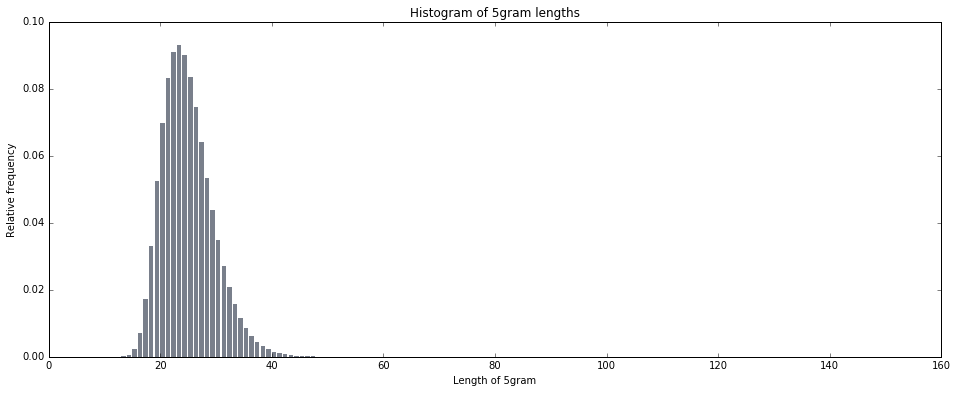

In [34]:
%matplotlib inline

import numpy as np
import pandas
import matplotlib.pyplot as plt

def plot_hist(output):
    frequencies = np.array(output)
    density = np.column_stack((frequencies[:,1], frequencies[:,0] / sum(frequencies[:,0])))

    plt.figure(figsize=(16, 6))
    plt.bar(density[:,0], density[:,1], color='#797f8b', edgecolor="none")
    plt.xlabel("Length of 5gram")
    plt.ylabel("Relative frequency")
    plt.title("Histogram of 5gram lengths")
    
plot_hist(output)

## HW5.4: Synonym detection

### Build stripes of word co-occurrence for the 9,000 words ranked 1,001 - 10,000

#### First we need to extract our basis using data from a previous job

In [30]:
# Copy results from S3 so we can extract our basis
!aws s3 cp s3://ms-w261-hw05/hw5_3b/part-00000 topWords.txt

download: s3://ms-w261-hw05/hw5_3b/part-00000 to ./topWords.txt


In [125]:
basis = []

with open('topWords.txt','r') as myfile:
    count = 0
    for line in myfile:
        if count > 1000 and count <= 10000:
            fields = line.strip().split('\t')
            word = eval(fields[1])
            basis.append(word)
        count += 1

with open('basisWords.txt','w') as myfile:
    for word in basis:
        myfile.write(word+'\n')

#### We also need to create our unit testing files

In [36]:
output = [['A', {'X':20, 'Y':30, 'Z':5}],
          ['B', {'X':100, 'Y':20}],
          ['C', {'M':5, 'N':20, 'Z':5}]]

with open('outputUnit.txt', 'w') as myfile:
    for out in output:
        myfile.write(str(out[0])+'\t'+str(out[1])+'\n')

In [37]:
%%writefile unitBasis.txt
A
B
C
M
N
X
Y
Z

Overwriting unitBasis.txt


#### Create co-occurrence matrix

In [127]:
%%writefile MRJob5_4_1.py
from mrjob.job import MRJob
from mrjob.step import MRStep

class stripes(MRJob):
    
    """
    Build stripes
    - Read in basis words from basisWords.txt
    - For each 5-gram:
       - Deduplicate the words in the 5-gram, then sort alphabetically
       - Extract count
       - Build stripe: (word1, {word2: x, word3: y, ...})
       
    """
    
    def mapper_buildStripe_init(self):
        self.numDocuments = 0
        self.vocab = set()
        with open('basisWords.txt','r') as myfile:
            for word in myfile:
                self.vocab.add(word.strip())
        
    def mapper_buildStripe(self, _, line):
        fields = line.strip().split('\t')
        words = fields[0].lower().split()
        wordList = sorted(list(set(words)))
        count = float(fields[1])
        self.numDocuments += count
        for index1 in range(len(wordList)-1):
            stripe = {}
            if wordList[index1] in self.vocab:
                for index2 in range(index1+1,len(wordList)):
                    if wordList[index2] in self.vocab:
                        stripe[wordList[index2]] = count
            if len(stripe) > 0:
                yield wordList[index1], stripe
                
    def mapper_buildStripe_final(self):
        yield '*total', {'*total':self.numDocuments}
            
    def combiner_buildStripe(self, key, values):
        stripe = {}
        for val in values:
            for word in val:
                if word in stripe:
                    stripe[word] += val[word]
                else:
                    stripe[word] = val[word]
        yield key, stripe
        
    def reducer_buildStripe_init(self):
        self.numDocs = 0
    
    def reducer_buildStripe(self, key, values):
        stripe = {}
        for val in values:
            for word in val:
                if word in stripe:
                    stripe[word] += val[word]
                else:
                    stripe[word] = val[word]
        if key == '*total':
            self.numDocs = stripe['*total']
        else:
            for word in stripe:
                stripe[word] /= self.numDocs
            yield key, stripe
    
            
        
    """
    Multi-step pipeline definitions
    Based on user input when calling runner function
    """
    def steps(self):
        return [
            MRStep(mapper_init=self.mapper_buildStripe_init,
                   mapper=self.mapper_buildStripe,
                   mapper_final=self.mapper_buildStripe_final,
                   combiner=self.combiner_buildStripe,
                   reducer_init=self.reducer_buildStripe_init,
                   reducer=self.reducer_buildStripe,
                   jobconf={'mapred.reduce.tasks': 1})
        ]
    

if __name__ == '__main__':
    stripes.run()

Overwriting MRJob5_4_1.py


In [128]:
from MRJob5_4_1 import stripes

def runJob5_4_1(filename, s3bucket, basis):

    #mr_job = stripes(args=[filename, '--file', basis])
    #mr_job = stripes(args=[filename, '-r', 'hadoop', '--hadoop-home', '/usr/', '--file', basis])
    mr_job = stripes(args=[filename, '-r', 'emr', '--file', basis, '--no-output', '--output-dir', s3bucket,
                           '--emr-job-flow-id', 'j-98XEIC78B7U2'])
    
    output = []
    
    with mr_job.make_runner() as runner: 
        # Run MRJob
        runner.run()

        # Write stream_output to file
        for line in runner.stream_output():
            out = mr_job.parse_output_line(line)
            output.append(out)
            
    return output

In [44]:
# Test our matrix creation on a small subset of data
output = runJob5_4_1('./filtered-5Grams/googlebooks-eng-all-5gram-20090715-0-filtered.txt', 'none', 'basisWords.txt')

The have been translated as follows
 mapred.reduce.tasks: mapreduce.job.reduces


In [47]:
for i in range(10):
    print output[i]

('alternate', {'viewing': 1.6005761449506742e-06})
("alzheimer's", {'dementia': 3.532979051659415e-06})
('amidst', {'tumult': 1.5615377023909016e-06, 'restless': 8.393265150351096e-07})
('ammonium', {'hydroxide': 1.522499259831129e-06})
('anemia', {'pernicious': 1.1321148342334037e-06})
('annum', {'thereon': 1.3468262683121526e-06})
('approximated', {'subcutaneous': 2.3423065535863526e-06})
('architectural', {'decoration': 8.978841788747684e-07})
('articular', {'cartilage': 9.954802852741998e-07})
('authoritative', {'interpreter': 9.759610639943135e-07})


#### Run on EMR on full data set -- this will get us the top right of the co-occurrence matrix

In [129]:
myfile = 's3://filtered-5grams/'
mybasis = 'basisWords.txt'
output_bucket = 's3://ms-w261-hw05/hw5_4_1'

!aws s3 rm --recursive {output_bucket}

output = runJob5_4_1(myfile, output_bucket, mybasis)

In [130]:
# Check the first record
print output[0]

('ab', {'essay': 4.238952276324725e-09, 'represent': 1.5007909606892538e-07, 'consul': 4.844516887228257e-09, 'personally': 7.165847895691797e-09, 'rod': 3.169121463728485e-08, 'month': 1.9781777289515385e-08, 'hath': 9.719312005001691e-08, 'consists': 1.3019639134425941e-08, 'centers': 6.358428414487087e-09, 'segments': 3.239770668333897e-08, 'division': 1.7359518845901255e-08, 'amplifier': 9.18439659870357e-09, 'void': 1.857064806770832e-07, 'squares': 6.963993025390619e-08, 'cable': 9.588106339305926e-09, 'die': 9.285324033854159e-09, 'p': 1.5845607318642425e-08, 'vector': 4.6426620169270795e-09, 'yale': 1.392798605078124e-08, 'lever': 7.771412506595329e-09, 'round': 4.4408071466259026e-09, 'estimates': 1.3625203745329473e-08, 'prediction': 1.78641560216542e-08, 'dynamics': 6.15657354418591e-09, 'honors': 4.339879711475314e-09, 'index': 4.037097406023548e-09, 'desirous': 1.8066010891955377e-08, 'supplied': 1.2615929393823586e-08, 'uniform': 3.0278230545176605e-08, 'journal': 8.47790

### Using two (symmetric) comparison methods of your choice, pairwise compare all stripes

In [113]:
%%writefile MRJob5_4_2.py
from mrjob.job import MRJob
from mrjob.step import MRStep
from itertools import combinations

class similarity(MRJob):
    
    """
    Specify some custom options so we only have to write one MRJob class for each part
    """
    def configure_options(self):
        super(similarity, self).configure_options()
        self.add_passthrough_option('--method', default='jaccard')
    
    """
    Build the full co-occurrence matrix
    - For each partial stripe, emit the stripe and the inverse stripe
    - Example: (dog, {cat:2, bird:3})
       - Emit original (dog, {cat:2, bird:3})
       - Emit inverse (cat, {dog:2}), (bird, {dog:3})
    """
    
    def mapper_buildFullMatrix(self, _, line):
        fields = line.strip().split('\t')
        word1 = fields[0]
        stripe = eval(fields[1])
        yield word1, stripe
        for word2 in stripe:
            yield word2, {word1: stripe[word2]}
        
    def reducer_buildFullMatrix(self, key, values):
        stripe = {}
        for val in values:
            for word in val:
                if word in stripe:
                    stripe[word] += val[word]
                else:
                    stripe[word] = val[word]
        yield key, stripe
    
    """
    Jaccard similarity
    - We need to look at all pairs in the basis
    - We only emit anything if one item in the pair has a value
    - We binarize on whether the co-occurrence support is > 0
    - Emit (word1, word2), (word1 and word2, word1, word2)
    """
    
    def mapper_Jaccard_init(self):
        self.vocab = set()
        with open('basisWords.txt','r') as myfile:
            for word in myfile:
                self.vocab.add(word.strip())
        self.allPairs = list(combinations(sorted(self.vocab),2))
        
    def mapper_Jaccard(self, key, values):
        for pair in self.allPairs:
            i = pair[0] in values
            j = pair[1] in values
            if i or j:
                yield (pair[0], pair[1]), ((i and j)+0, i+0, j+0)
                
    def combiner_Jaccard(self, key, values):
        intersect = 0
        i = 0
        j = 0
        for val in values:
            intersect += val[0]
            i += val[1]
            j += val[2]
        yield key, (intersect, i, j)
        
    def reducer_Jaccard(self, key, values):
        intersect = 0.0
        i = 0
        j = 0
        for val in values:
            intersect += val[0]
            i += val[1]
            j += val[2]
        yield key, intersect / (i + j - intersect)       
    
    """
    Multi-step pipeline definitions
    Based on user input when calling runner function
    """
    def steps(self):
        self.method = self.options.method
        if self.method == 'jaccard':
            return [
                MRStep(mapper=self.mapper_buildFullMatrix,
                       combiner=self.reducer_buildFullMatrix,
                       reducer=self.reducer_buildFullMatrix),
                MRStep(mapper_init=self.mapper_Jaccard_init,
                       mapper=self.mapper_Jaccard,
                       combiner=self.combiner_Jaccard,
                       reducer=self.reducer_Jaccard)
            ]
    

if __name__ == '__main__':
    similarity.run()

Overwriting MRJob5_4_2.py


In [132]:
from MRJob5_4_2 import similarity

def runJob5_4_2(filename, s3bucket, basis, method):

    #mr_job = similarity(args=[filename, '--file', basis, '--method', method])
    #mr_job = similarity(args=[filename, '-r', 'hadoop', '--hadoop-home', '/usr/', '--file', basis, '--method', method])
    mr_job = similarity(args=[filename, '-r', 'emr', '--file', basis, '--no-output', '--output-dir', s3bucket,
                              '--emr-job-flow-id', 'j-98XEIC78B7U2', '--method', method])
    
    output = []
    
    with mr_job.make_runner() as runner: 
        # Run MRJob
        runner.run()

        # Write stream_output to file
        for line in runner.stream_output():
            out = mr_job.parse_output_line(line)
            output.append(out)
            
    return output

In [112]:
myfile = 'outputUnit.txt'
mybasis = 'unitBasis.txt'

output = runJob5_4_2(myfile, 'none', mybasis, 'jaccard')
print output

[(['A', 'B'], 0.6666666666666666), (['A', 'C'], 0.2), (['A', 'M'], 0.0), (['A', 'N'], 0.0), (['A', 'X'], 0.0), (['A', 'Y'], 0.0), (['A', 'Z'], 0.0), (['B', 'C'], 0.0), (['B', 'M'], 0.0), (['B', 'N'], 0.0), (['B', 'X'], 0.0), (['B', 'Y'], 0.0), (['B', 'Z'], 0.0), (['C', 'M'], 0.0), (['C', 'N'], 0.0), (['C', 'X'], 0.0), (['C', 'Y'], 0.0), (['C', 'Z'], 0.0), (['M', 'N'], 1.0), (['M', 'X'], 0.0), (['M', 'Y'], 0.0), (['M', 'Z'], 0.5), (['N', 'X'], 0.0), (['N', 'Y'], 0.0), (['N', 'Z'], 0.5), (['X', 'Y'], 1.0), (['X', 'Z'], 0.3333333333333333), (['Y', 'Z'], 0.3333333333333333)]


#### Check some hand calculations to be sure

Full co-occurrence matrix:

 |A|B|C|M|N|X|Y|Z
-|-|-|-|-|-|-|-|-
**A**|0|0|0|0|0|20|30|5
**B**|0|0|0|0|0|100|20|0
**C**|0|0|0|5|20|0|0|0
**M**|0|0|5|0|0|0|0|0
**N**|0|0|20|0|0|0|0|0
**X**|20|100|0|0|0|0|0|0
**Y**|30|20|0|0|0|0|0|0
**Z**|5|0|5|0|0|0|0|0

Let's check the Jaccard similarity between A and B:

$\frac{|A \cap B|}{|A|+|B|-|A \cap B|} = \frac{2}{3+2-2}=\frac{2}{3}$

Let's check the Jaccard similarity between A and C:

$\frac{|A \cap C|}{|A|+|C|-|A \cap C|} = \frac{1}{3+3-1}=\frac{1}{5}$

Both of these calculations check out!


In [133]:
myfile = 's3://ms-w261-hw05/hw5_4_1/part-00000'
mybasis = 'basisWords.txt'
output_bucket = 's3://ms-w261-hw05/hw5_4_2'

!aws s3 rm --recursive {output_bucket}

output = runJob5_4_2(myfile, output_bucket, mybasis, 'jaccard')

ERROR:mrjob.emr:Job on job flow j-98XEIC78B7U2 failed with status WAITING: Cluster ready after last step failed.


KeyboardInterrupt: 

In [135]:
# Terminate job flow so we don't rack up AWS expenses
!python -m mrjob.tools.emr.terminate_job_flow j-98XEIC78B7U2

using configs in /etc/mrjob.conf
using existing scratch bucket mrjob-ac40f1afcc0b86ce
using s3://mrjob-ac40f1afcc0b86ce/tmp/ as our scratch dir on S3
Terminated job flow j-98XEIC78B7U2
